<a href="https://colab.research.google.com/github/PedroHGMS/rna_trabalho_final/blob/main/trabalho_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')
proj_path = 'drive/MyDrive/rna/trabalho_final/'

Mounted at /content/drive


In [5]:
pip install import_ipynb ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Importando funções que carregam os datasets
import import_ipynb
import ipynb
import sys, os
sys.path.append(os.path.abspath(proj_path+'Datasets/'))
from ipynb.fs.full.load_datasets import *

In [7]:
# Funções gerais

def normalize(X):
    return (X-np.min(X,0))/(np.max(X,0)-np.min(X,0))

def print_dictionary(d):
  for k in d.keys():
    if type(d[k]) == np.ndarray:
      print(f"{k}.shape: {d[k].shape}")
    elif type(d[k])==int:
      print(f"{k}: {d[k]:.3E}")
    else:
      print(f"{k}: {d[k]}")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import csv
import math
import time
import csv
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
from scipy.stats import multivariate_normal
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output

In [63]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras import regularizers, layers, Sequential, models, optimizers

In [31]:
# Definição de funções para o k-fold
def split_dataset(X, Y, ratio):
  '''
    Separa X e Y de acordo com os ratio passado.
    input:
      X: um np.ndarray (N, d)
      Y: um np.ndarray (N, 1)
      ratio: uma lista ou ndarray com 2 ou 3 valores
    output:
      Um dicionário com a divisão de X e Y em 'train' e 'test', se ratio tiver 2 valores,
      ou 'train', 'val' e 'test'
  '''
  return_dict = {}
  ratio = np.array(ratio)

  # Confere valores de entrada
  if (not (np.isclose(ratio.sum(), 1))) or (ratio.shape[0]==0) or (ratio.shape[0]>=4):
    print('Erro: Ratio deve ter 2 ou 3 valores e a soma dos valores deve ser igual a 1.')
    return {}

  # Número de amostras e dimensão de entrada
  N, d = X.shape

  # Faz as permutações, para embaralhar X e Y de forma igual
  permutations = np.random.permutation(X.shape[0])

  # Valores do limite entre cada partição
  ratio_indices = (N*ratio.cumsum()).astype(int)

  # Divisão de treino
  return_dict['X_train'] = X[permutations[0:ratio_indices[0]]]
  return_dict['Y_train'] = X[permutations[0:ratio_indices[0]]]

  # Divisão
  if(ratio.shape[0]==2):
    return_dict['X_test'] = X[permutations[ratio_indices[0]:ratio_indices[1]]]
    return_dict['Y_test'] = X[permutations[ratio_indices[0]:ratio_indices[1]]]
  elif(ratio.shape[0]==3):
    return_dict['X_val'] = X[permutations[ratio_indices[0]:ratio_indices[1]]]
    return_dict['Y_val'] = X[permutations[ratio_indices[0]:ratio_indices[1]]]

    return_dict['X_test'] = X[permutations[ratio_indices[1]:ratio_indices[2]]]
    return_dict['Y_test'] = X[permutations[ratio_indices[1]:ratio_indices[2]]]
  return return_dict

def split_k_fold(X, Y, k=10):
  '''
    Divide X e Y em k folds, não aleatoriza
    Retorna uma tuple com arrays
  '''
  # Número de amostras e dimensão de entrada
  N, d = X.shape
  
  # limite entre cada fold em indices
  lim = np.linspace(0, N, k+1).astype(int)
  
  X_array = []
  Y_array = []
  for i in range(k):
    idx = np.array(range(lim[i],lim[i+1]))
    X_array.append(X[idx])
    Y_array.append(Y[idx])
  return (X_array, Y_array)

In [45]:
# Função do k-fold

def kfold(dataset, lamb = 0, n_neuronios = 10, num_epochs = 100, k=10, ratio=[.7, .3], train_verbose=False):
  '''
    Calcula o erro de validação k-fold para um dataset
    inputs:
      model: modelo não treinado do keras
      dataset: dicionário com X e Y
      ratio = divisão entre o dataset de treinamento e teste
    output:
      Retorna o erro d evalidação e de teste de cada fold
  '''
  # Recuperando dataset
  X = dataset['X']
  Y = dataset['Y']
  name = dataset['name']
  task = dataset['task']


  if task=='regression':
    track_metric = 'mse'
    metric_mode = 'min'
  elif task=='classification':
    track_metric = 'binary_accuracy'
    metric_mode = 'max'
  else:
    print(f'"Task" do dataset inválida, deve ser "regression" ou "classificação". Atual: {task}')


  # Número de amostras e dimensão de entrada
  N, d = X.shape

  # Sepração entre treino e teste
  dataset_separado =  split_dataset(X, Y, ratio = ratio)
  X_test, Y_test = dataset_separado['X_test'], dataset_separado['Y_test']
  X_train, Y_train = dataset_separado['X_train'], dataset_separado['Y_train']

  # k-fold
  # Separação dos k-folds
  X_folds, Y_folds = split_k_fold(X=X_train, Y=Y_train, k=k)

  # Loop para usar cada fold para validação de cada vez
  melhor_erro_val = np.zeros((k))
  erro_teste = np.zeros((k))
  kfold_pbar = tqdm(range(k))
  for i in (kfold_pbar):
    kfold_pbar.set_description('k-fold')
    # Separação dos indices de cada k-fold (valores de 0 a k)
    fold_idx = list(range(k))
    val_idx = fold_idx.pop(i)
    train_idx = fold_idx

    # Separação de cada k-fold e transformando em um np.ndarray
    X_train_folds = np.concatenate([X_folds[e] for e in train_idx])
    X_val_fold = X_folds[val_idx]

    Y_train_folds = np.concatenate([Y_folds[e] for e in train_idx])
    Y_val_fold = Y_folds[val_idx]

    # Definição do modelo
    model = Sequential([
      layers.Input(shape=(d)),
      layers.Dense(n_neuronios, activation='tanh', kernel_regularizer=regularizers.L2(l2=lamb)),
      layers.Dense(1, activation='linear', kernel_regularizer=regularizers.L2(l2=lamb))
    ])

    # Compilação do modelo, escolhendo o otimizador, função de perda e métrica de validação
    model.compile(optimizer='sgd',
                  loss='mse',
                  metrics=[track_metric])
    
    # Definindo um checkpoint para salvar o modelo com melhor metrica de validação
    checkpoint = ModelCheckpoint(filepath=proj_path+f'Modelos/melhor_modelo_{i}.hdf5', 
                              monitor=f'val_{track_metric}',
                              verbose=0, 
                              save_best_only=True,
                              mode=metric_mode)
    # if task=='regression':

    #   model.compile(optimizer='sgd',
    #                 loss='mse')
      
    #   checkpoint = ModelCheckpoint(filepath=proj_path+f'Modelos/melhor_modelo_{i}.hdf5', 
    #                           monitor='val_loss',
    #                           verbose=0, 
    #                           save_best_only=True,
    #                           mode='min')
    # elif task=='classification':

    #   model.compile(optimizer='sgd',
    #               loss='mse',
    #               metrics=['accuracy'])
    
    #   checkpoint = ModelCheckpoint(filepath=proj_path+f'Modelos/melhor_modelo_{i}.hdf5', 
    #                           monitor='val_accuracy',
    #                           verbose=0, 
    #                           save_best_only=True,
    #                           mode='min')
    # else:
    #   print(f'"Task" do dataset inválida, deve ser "regression" ou "classificação". Atual: {task}')

    # Treinamento com X_train_folds
    callbacks = []
    callbacks.append(checkpoint)
    if train_verbose==True:
      callbacks.append(TqdmCallback(verbose=1, leave=False))
    history = model.fit(x=X_train_folds, y=Y_train_folds, validation_data=(X_val_fold, Y_val_fold),
                        epochs=num_epochs, verbose=0, callbacks=[checkpoint])

    # Gráficos de treinamento
    # plt.plot(np.array(history.history['loss']).reshape(-1,10).mean(axis=1).reshape(-1,1),label='train loss')
    # plt.plot(np.array(history.history['val_loss']).reshape(-1,10).mean(axis=1).reshape(-1,1),label='val loss')
    # plt.legend()
    # plt.show()

    # Validação com X_val_fold
    melhor_erro_val[i] = np.array(history.history[f'val_{track_metric}']).min()
      
  
  # Erro de validação médio dos k-folds
  # plt.hist(melhor_erro_val, bins=k)
  # plt.show()
  print('Erro de validação: ',melhor_erro_val.mean(),'+-', melhor_erro_val.var()**0.5)

  # Teste com X_test
  test_pbar = tqdm(range(k), leave=False)
  for i in test_pbar:
    test_pbar.set_description('Testando modelos')
    melhor_modelo = models.load_model(proj_path+f'Modelos/melhor_modelo_{i}.hdf5')
    erro_teste[i] = melhor_modelo.evaluate(X_test,Y_test, verbose=0, return_dict=True)[track_metric]

  # plt.hist(erro_teste, bins=k)
  # plt.show()
  print('Erro de Teste:     ',erro_teste.mean(),'+-', erro_teste.var()**0.5)

  return (np.copy(melhor_erro_val), np.copy(erro_teste))
  

###########################
# Testes da função K-fold #
###########################

# Carregando dataset
dataset = load_dataset_3()
dataset['X'] = normalize(dataset['X'])
k = 10
split = [.8, .2]

# Printando o dataset
print('Dataset:')
print_dictionary(dataset)
print('#'*30)

kfold(dataset, lamb=0, n_neuronios=10, num_epochs=100, k=10, ratio=[.8, .2])

Dataset:
X.shape: (690, 14)
Y.shape: (690, 1)
task: classification
name: Credit Approval
##############################


  0%|          | 0/10 [00:00<?, ?it/s]

Erro de validação:  0.2583580732345581 +- 0.027630742304714757


  0%|          | 0/10 [00:00<?, ?it/s]

Erro de Teste:      0.2806935846805573 +- 0.005828669220117752


(array([0.22467533, 0.24415585, 0.28831169, 0.30909091, 0.22193877,
        0.24285716, 0.29220778, 0.25844157, 0.24935065, 0.25255102]),
 array([0.27846792, 0.28260869, 0.2789855 , 0.27743271, 0.27432713,
        0.27432713, 0.28571427, 0.29399586, 0.28467911, 0.27639753]))

In [126]:
# Testes para descobrir qunatos neurônios são precisos para cada dataset
datasets = [
            load_dataset_1(),
            load_dataset_2(),
            load_dataset_3(),
            load_dataset_4(),
            load_dataset_5()
            ]

neuronios = [3, 10, 30, 50, 100]
num_epochs = 1000
num_rep = 10

tqdm_datasets = tqdm([2, 3, 4, 1])
for i in tqdm_datasets:#range(len(datasets)):
  # Carregando datasets
  dataset = datasets[i]
  # print(f'\nDataset {i+1}:')
  # print_dictionary(dataset)
  tqdm_datasets.set_description(f"Datasets | Atual: {dataset['name']}")

  dataset['X'] = normalize(dataset['X'])
  task = dataset['task']
  if dataset['task']=='classification':
    dataset['Y'][dataset['Y']==-1] = 0

  # Definindo o tipo de tarefa
  if task=='regression':
    track_metric = 'mse'
    metric_mode = 'min'
  elif task=='classification':
    track_metric = 'binary_accuracy'
    metric_mode = 'max'

  # Testando vários números de neurônios
  erros_neuronios = np.zeros((len(neuronios), num_rep))
  tqdm_neuronios = tqdm(range(len(neuronios)), leave=False)
  for num_neuronios_idx in tqdm_neuronios:
    num_neuronios = neuronios[num_neuronios_idx]
    tqdm_neuronios.set_description(f"Num_neur | Atual: {num_neuronios}")

    # Repetindo o treinamento várias vezes
    erros_rep = np.zeros((num_rep))
    tqdm_it = tqdm(range(num_rep), leave=False)
    for it in tqdm_it:
      tqdm_it.set_description(f"Repetições")

      # Definindo modelo
      model = Sequential([
        layers.Input(shape=(dataset['X'].shape[1])),
        layers.Dense(num_neuronios, activation='tanh'),
        layers.Dense(1, activation='linear')
      ])

      # Learning rate schedule
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=0.0007,
          decay_steps=50,
          decay_rate=0.975)

      # Otimizadores
      adam = tf.keras.optimizers.Adam(
          learning_rate=lr_schedule,
          beta_1=0.9,
          beta_2=0.999
      )

      sgd = tf.keras.optimizers.SGD(
          learning_rate=lr_schedule
      )

      # Compilando modelo
      model.compile(optimizer=adam, metrics=[track_metric],
                loss='mse')
      
      # Treinamento
      history = model.fit(dataset['X'], dataset['Y'], epochs=num_epochs, verbose=0)

      # Erro de cada treinamento de cada numero de neuronios
      if metric_mode=='min':
        erros_rep[it] = np.array(history.history[track_metric]).min()
      elif metric_mode=='max':
        erros_rep[it] = np.array(history.history[track_metric]).max()

    # Erro de treinamento cada tipo de neurônios
    erros_neuronios[num_neuronios_idx, :] = erros_rep
  # Plot de erro para cada neurônios
  plt.plot(neuronios, erros_neuronios.mean(1))
  plt.fill_between(neuronios, erros_neuronios.mean(1)+erros_neuronios.var(1)**0.5, erros_neuronios.mean(1)-erros_neuronios.var(1)**0.5, alpha=0.2)
  plt.title(f"Dataset: {dataset['name']}\nNúmero de neurônios X {track_metric}")
  plt.ylabel(track_metric)
  plt.xlabel('Número de neurônios')
  plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

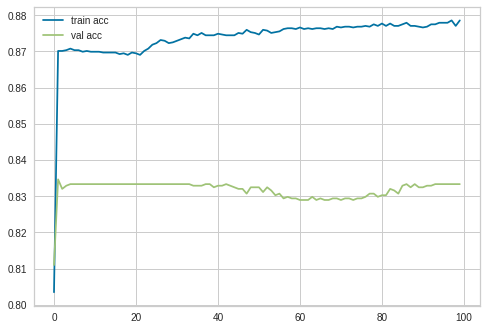

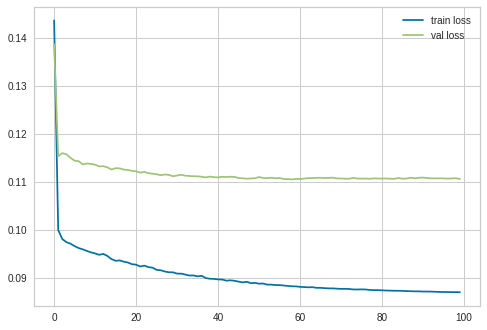

In [117]:
dataset = load_dataset_3()
dataset['X'] = normalize(dataset['X'])
dataset['Y'][dataset['Y']==-1] = 0

model = Sequential([
    layers.Input(shape=(dataset['X'].shape[1])),
    layers.Dense(30, activation='tanh'),
    layers.Dense(1, activation='linear')
])

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=50,
    decay_rate=0.99)

# Otimizadores
adam = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999
)

sgd = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule
)

model.compile(optimizer=adam, metrics=['binary_accuracy'],
              loss='mse')
callbacks=[]
# callbacks=[TqdmCallback(verbose=1)]
history = model.fit(dataset['X'], dataset['Y'], epochs=1000, validation_split=0.33, verbose=0, callbacks=callbacks)
# history = model.fit(dataset['X'][0:100], dataset['Y'][0:100], epochs=500, verbose=0, callbacks=[TqdmCallback(verbose=1)])

plt.plot(np.array(history.history['binary_accuracy']).reshape(-1,10).mean(axis=1).reshape(-1,1),label='train acc')
plt.plot(np.array(history.history['val_binary_accuracy']).reshape(-1,10).mean(axis=1).reshape(-1,1),label='val acc')
plt.legend()
plt.show()

plt.plot(np.array(history.history['loss']).reshape(-1,10).mean(axis=1).reshape(-1,1),label='train loss')
plt.plot(np.array(history.history['val_loss']).reshape(-1,10).mean(axis=1).reshape(-1,1),label='val loss')
plt.legend()
plt.show()

In [ ]:
N = 100
X = np.linspace(-5,5,N).reshape(-1,1)
Y = np.sin(X).reshape(-1, 1) + np.random.normal(scale=0.2, size=100).reshape(-1,1)

plt.plot(X,np.sin(X))
plt.scatter(X,Y)
X.shape, Y.shape

((20, 1), (20, 1))

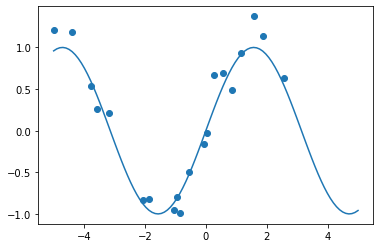

In [ ]:
permutations = np.random.permutation(X.shape[0])

slice_size = 20
X_slice = X[permutations[0:slice_size]]
Y_slice = Y[permutations[0:slice_size]]

plt.plot(X,np.sin(X))
plt.scatter(X_slice,Y_slice)
X_slice.shape, Y_slice.shape

In [ ]:
# Treina vários modelos
num_it = 200
num_modelos = 10
models = []
histories = []

for _ in tqdm(range(num_modelos)):
  model = keras.Sequential([
      keras.layers.Input(shape=(1)),
      keras.layers.Dense(30, activation='tanh'),
      keras.layers.Dense(1, activation='linear')
  ])

  model.compile(optimizer='sgd',
                loss='mse',
                metrics=['mse'])

  history = model.fit(X, Y, epochs=int(num_it), validation_split=0.33, verbose=0)

  models.append(model)
  histories.append(history)

# y_hat = model.predict(X)
# plt.plot(X,y_hat)
# plt.scatter(X,Y)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Avalia os modelos
y_hat = np.zeros((num_modelos, *(Y.shape)))
for i in tqdm(range(num_modelos)):
  y_hat[i] = models[i].predict(X)

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 100, 1)

  0%|          | 0/10 [00:00<?, ?it/s]

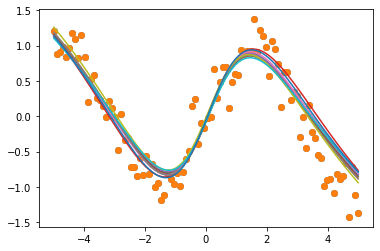

In [ ]:
# Plota resultados médios
y_hat_mean = y_hat.mean(axis=(0,2))
plt.plot(X,y_hat_mean)
plt.scatter(X,Y)

# plotar todos modelos em um grid
for i in tqdm(range(num_modelos)):
  plt.plot(X,y_hat[i])
  plt.scatter(X,Y)
  plt.show()

In [ ]:
num_it = 100
history = model.fit(X, Y, epochs=int(num_it), validation_split=0.33)

y_hat = model.predict(X)
plt.plot(X,y_hat)
plt.scatter(X,Y)
# plt.plot(X,np.sin(X))

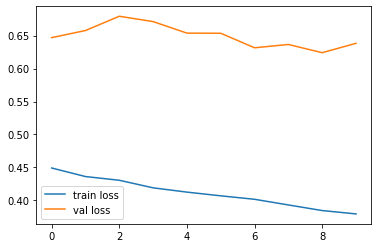

In [ ]:
plt.plot(np.array(history.history['loss']).reshape(-1,10).mean(axis=1).reshape(-1,1),label='train loss')
plt.plot(np.array(history.history['val_loss']).reshape(-1,10).mean(axis=1).reshape(-1,1),label='val loss')
plt.legend()